In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from glob import glob
import os

In [2]:
import tensorflow as tf
import numpy as np

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
tf.__version__

'1.5.0'

In [4]:
image_path = "00003102d3ec9a46cb5cd2fd95473b8d.jpg"

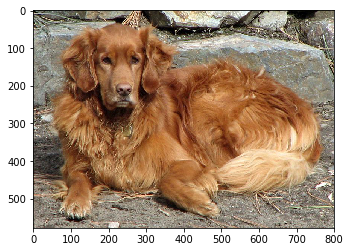

In [5]:
from PIL import Image
plt.imshow(Image.open(image_path))

In [6]:
ResNet50 = tf.keras.applications.ResNet50
preprocess_input = tf.keras.applications.resnet50.preprocess_input
image = tf.keras.preprocessing.image

In [7]:
resnet_model = ResNet50(weights='imagenet', include_top=False)

In [8]:
def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return resnet_model.predict(x)[0][0][0]

In [9]:
f = extract_features(image_path)
print(f[:5])
print(len(f))

[0.03233031 0.05817417 0.37201586 0.         0.        ]
2048


In [49]:
small_out = image.load_img(image_path, target_size=(28, 28))

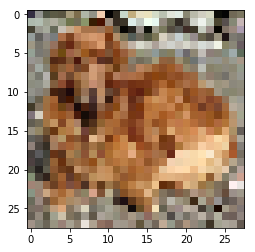

In [52]:
plt.imshow(small_out)

(28, 28, 3)


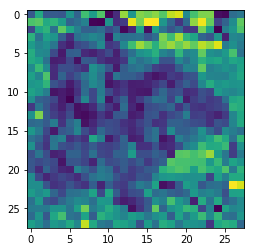

In [73]:
print(image.img_to_array(small_out).shape)
plt.imshow(image.img_to_array(small_out)[:,:,2])

In [63]:
Input = tf.keras.layers.Input
Dense = tf.keras.layers.Dense
Conv2D = tf.keras.layers.Conv2D
MaxPooling2D = tf.keras.layers.MaxPooling2D
UpSampling2D = tf.keras.layers.UpSampling2D
Model = tf.keras.models.Model
Reshape = tf.keras.layers.Reshape
#from tf.keras import backend as K

In [64]:
input_img = Input(shape=(128, ))  # adapt this if using `channels_first` image data format

x = Reshape([4, 4, 8] )(input_img)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [65]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [66]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128)               0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 4, 4, 8)           584       
_________________________________________________________________
up_sampling2d_7 (UpSampling2 (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 8)           584       
_________________________________________________________________
up_sampling2d_8 (UpSampling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 16)        1168      
__________

In [70]:
TensorBoard = tf.keras.callbacks.TensorBoard

autoencoder.fit(np.array([f[:128]]), 
                #np.array([np.expand_dims(image.img_to_array(small_out), axis=0)]),
                np.reshape([image.img_to_array(small_out)[:,:,0]], (1, 28, 28, 1)).astype('float32') / 255.,
                epochs=50,
               )
                #batch_size=128,
                #shuffle=True,
                #validation_data=(x_test, x_test),
                #callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/50
1/1 [==============================]1/1 [==============================] - 0s 9ms/step - loss: 0.6896

Epoch 2/50
1/1 [==============================]1/1 [==============================] - 0s 6ms/step - loss: 0.6886

Epoch 3/50
1/1 [==============================]1/1 [==============================] - 0s 6ms/step - loss: 0.6876

Epoch 4/50
1/1 [==============================]1/1 [==============================] - 0s 7ms/step - loss: 0.6866

Epoch 5/50
1/1 [==============================]1/1 [==============================] - 0s 7ms/step - loss: 0.6855

Epoch 6/50
1/1 [==============================]1/1 [==============================] - 0s 11ms/step - loss: 0.6844

Epoch 7/50
1/1 [==============================]1/1 [==============================] - 0s 7ms/step - loss: 0.6832

Epoch 8/50
1/1 [==============================]1/1 [==============================] - 0s 9ms/step - loss: 0.6818

Epoch 9/50
1/1 [==============================]1/1 [==============================] - 0

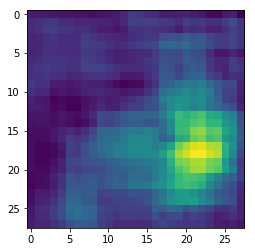

In [71]:
decoded_img = autoencoder.predict(np.array([f[:128]]))
plt.imshow(decoded_img.reshape(28, 28))

In [ ]:
def generator_block(input_node, input_shape, leaku_relu_alpha) :    
    channels, height, width = input_shape
    output_shape = (None, channels / 2, height * 2 + 2, width * 2 + 2)  
    
    block = Deconvolution2D(
        output_shape[1], 
        4, 4, 
        output_shape = output_shape, 
        border_mode='valid', 
        init='glorot_uniform', 
        subsample = (2, 2),
    )(input_node)
    block = Cropping2D(((1, 1), (1, 1)))(block)
    block = BatchNormalization(mode = 2)(block)
    block = LeakyReLU(leaku_relu_alpha)(block)

    return block


def build_generator(initial_size = (3, 3), channels_count = 32 * 32, leaky_relu_alpha = 0.2) :
    generator_input = Input(shape=[100])
    
    initial_height, initial_width = initial_size
    
    H = Dense(channels_count * initial_height * initial_width, init='glorot_normal')(generator_input)
    H = BatchNormalization(mode = 2)(H)
    H = LeakyReLU(0.2)(H)
    H = Reshape([channels_count, initial_height, initial_width] )(H) # nch

    # 4 layers result in x16 increased picture size, (3, 3) -> (48, 48)

    H = generator_block(H, (channels_count, initial_height, initial_width), leaky_relu_alpha)
    H = generator_block(H, (channels_count / 2 , initial_height * 2, initial_width * 2), leaky_relu_alpha)
    H = generator_block(H, (channels_count / 4 , initial_height * 4, initial_width * 4), leaky_relu_alpha)
    H = generator_block(H, (channels_count / 8 , initial_height * 8, initial_width * 8), leaky_relu_alpha)

    H = Convolution2D(channels_count / 32, 3, 3, border_mode='same', init='glorot_uniform')(H)
    H = BatchNormalization(mode = 2)(H)
    H = LeakyReLU(leaky_relu_alpha)(H)

    H = Convolution2D(3, 1, 1, border_mode='same', init='glorot_uniform')(H)
    generator_output = Activation('tanh')(H)

    generator = Model(generator_input, generator_output)
    generator_output_shape = (3, initial_height * 16, initial_width * 16)

    return generator, generator_input, generator_output_shape
